In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from utils import *

from PIL import Image

import time

In [87]:

# Quantization function
def quantize(tensor, bits):
    scale = 2**bits - 1
    tensor = torch.round(tensor * scale) / scale
    return tensor

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [89]:


# CIFAR-10 data loading and transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


In [90]:

def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )

    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out



# Define the model
model = LeNet().to(device)
model = model.to(device)

In [91]:
def train(model, num_epochs, device, compress_function=None, input_compress_settings=None):

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    
    # Lists to store metrics
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    
    # Track time and memory
    start_time = time.time()
    initial_memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        first = True
        for inputs, targets in trainloader:

          
          
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
        
            if first:
                if epoch == 1 or epoch == 10 or epoch == 20:
                    gradients = []

                    print("SAVING THE MODEL AND GRADIENTS FOR EPOCH = ", epoch)
                    # Save the model as a checkpoint
                    torch.save(model.state_dict(), f'checkpoints/model_epoch_{epoch}.pth')
                    for param in model.parameters():
                      if param.grad is not None:
                        gradients.append(param.grad.data.clone())
                    torch.save(gradients, f'checkpoints/gradients_epoch_{epoch}.pth')
        
                first = False
        
                # Apply gradient compression
                # if compress_function is not None and input_compress_settings is not None:
                #     for param in model.parameters():
                #         if param.grad is not None:
                #             param.grad.data = compress_function(param.grad.data, input_compress_settings)
        
                optimizer.step()
                running_loss += loss.item()

        print(f'Epoch {epoch + 1}, Train_Loss: {running_loss / len(trainloader)}')
        train_losses.append(running_loss / len(trainloader))



      # Save the gradients for epoch 1, 5, 10


        # Validate the model
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        print(f'Epoch {epoch + 1}, Test_Loss: {test_loss / len(testloader)}')
        test_losses.append(test_loss / len(testloader))
        print(f'Accuracy: {100 * correct / total}%')
        test_accuracies.append(100 * correct / total)
        print("###########################################")

    print('Finished Training')
    end_time = time.time()
    total_time = end_time - start_time
    final_memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else None
    memory_consumed = final_memory - initial_memory if torch.cuda.is_available() else None
    
    print('Finished Training')
    print(f'Total Training Time: {total_time:.2f} seconds')
    if torch.cuda.is_available():
        print(f'Memory Consumed: {memory_consumed / (1024 ** 2):.2f} MB')  # Convert bytes to MB
    
    return train_losses, test_losses, test_accuracies


In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot the metrics
def plot_metrics(train_losses, test_losses, test_accuracies, name=None):
    epochs = range(1, len(train_losses) + 1)
    
    sns.set(style="whitegrid")

    plt.figure(figsize=(14, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=train_losses, label='Training loss', color='blue', marker='o')
    sns.lineplot(x=epochs, y=test_losses, label='Test loss', color='red', marker='o')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs, y=test_accuracies, label='Test accuracy', color='green', marker='o')
    plt.title('Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()

    if name is not None:
        plt.savefig(f'images/{name}')
    plt.show()

In [93]:
#train
num_epochs = 22

train_losses, test_losses, test_accuracies = train(model, num_epochs, device, None, None)

# Plot the metrics
plot_metrics(train_losses, test_losses, test_accuracies)

print('Finished Training')


Epoch 1, Train_Loss: 0.011674891957236679
Epoch 1, Test_Loss: 3.2414615576780297
Accuracy: 10.0%
###########################################
SAVING THE MODEL AND GRADIENTS FOR EPOCH =  1
Epoch 2, Train_Loss: 0.008350068041125832
Epoch 2, Test_Loss: 2.6004096827929533
Accuracy: 10.0%
###########################################
Epoch 3, Train_Loss: 0.006692374758708202
Epoch 3, Test_Loss: 2.480828846557231
Accuracy: 10.0%
###########################################
Epoch 4, Train_Loss: 0.006210674715164067
Epoch 4, Test_Loss: 3.039524564260169
Accuracy: 10.0%
###########################################
Epoch 5, Train_Loss: 0.006926160944087426
Epoch 5, Test_Loss: 3.152564444119417
Accuracy: 10.0%
###########################################
Epoch 6, Train_Loss: 0.007706320804098378
Epoch 6, Test_Loss: 3.536915395833269
Accuracy: 10.0%
###########################################
Epoch 7, Train_Loss: 0.008688118146813435
Epoch 7, Test_Loss: 3.7177957794334313
Accuracy: 10.0%
###############

KeyboardInterrupt: 

In [ ]:
plot_metrics(train_losses, test_losses, test_accuracies)

Dummy label is 58.


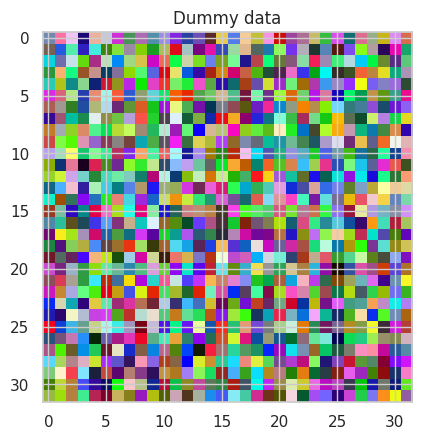

In [84]:
tp = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor()
])
tt = transforms.ToPILImage()

gt_data = tp(Image.open('images/me.jpg')).to(device)

gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([5]).long().to(device)
gt_label = gt_label.view(1, )
gt_onehot_label = label_to_onehot(gt_label, num_classes=100)

criterion = cross_entropy_for_onehot

dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())


In [94]:
def reconstruct(model, original_dy_dx, data_size, label_size):

    # generate dummy data and label
    dummy_data = torch.randn(data_size).to(device).requires_grad_(True)
    dummy_label = torch.randn(label_size).to(device).requires_grad_(True)

    plt.imshow(tt(dummy_data[0].cpu()))
    plt.title("Dummy data")
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

    history = []
    optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

    for iters in range(300):
        def closure():
            optimizer.zero_grad()
    
            pred = model(dummy_data)
            dummy_onehot_label = F.softmax(dummy_label, dim=-1)
            dummy_loss = criterion(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
            dummy_dy_dx = torch.autograd.grad(dummy_loss, model.parameters(), create_graph=True)
    
            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx): # TODO: fix the variablas here
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()
            # grad_diff = grad_diff / grad_count * 1000
            grad_diff.backward()
    
            return grad_diff
    
        optimizer.step(closure)
        if iters % 10 == 0:
            current_loss = closure()
            print(iters, "%.4f" % current_loss.item())
        history.append(tt(dummy_data[0].cpu()))


    
    history_tensors = [tp(img).to(device) for img in history]
    
    # Convert ground truth image to tensor
    gt_tensor = gt_data[0].to(device)
    
    # Calculate L2 loss
    l2_losses = []
    plt.figure(figsize=(12, 8))
    for img_tensor in history_tensors:
        l2_losses.append(torch.nn.L1Loss()(img_tensor, gt_tensor).item())
    
    # Print the total L2 loss
    sns.lineplot(x=range(len(l2_losses)), y=l2_losses)
    plt.title("L1 Loss")
    plt.show()

    plt.figure(figsize=(12, 8))
    for i in range(30):
      plt.subplot(3, 10, i + 1)
      plt.imshow(history[i * 10])
      plt.title("iter=%d" % (i * 10))
      plt.axis('off')

    plt.show()
    print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

Dummy label is 99.
0 156.7342
10 156.7338
20 156.7333
30 156.7328
40 156.7323
50 156.7316
60 156.7312
70 156.7307
80 156.7302
90 156.7296
100 156.7291
110 156.7287
120 156.7283
130 156.7277
140 156.7271
150 156.7265
160 156.7260
170 156.7250
180 156.7244
190 156.7238
200 156.7231
210 156.7226
220 156.7221
230 156.7216
240 156.7211
250 156.7206
260 156.7198
270 156.7193
280 156.7188
290 156.7181


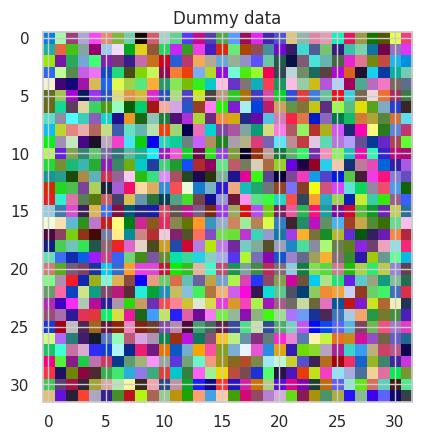

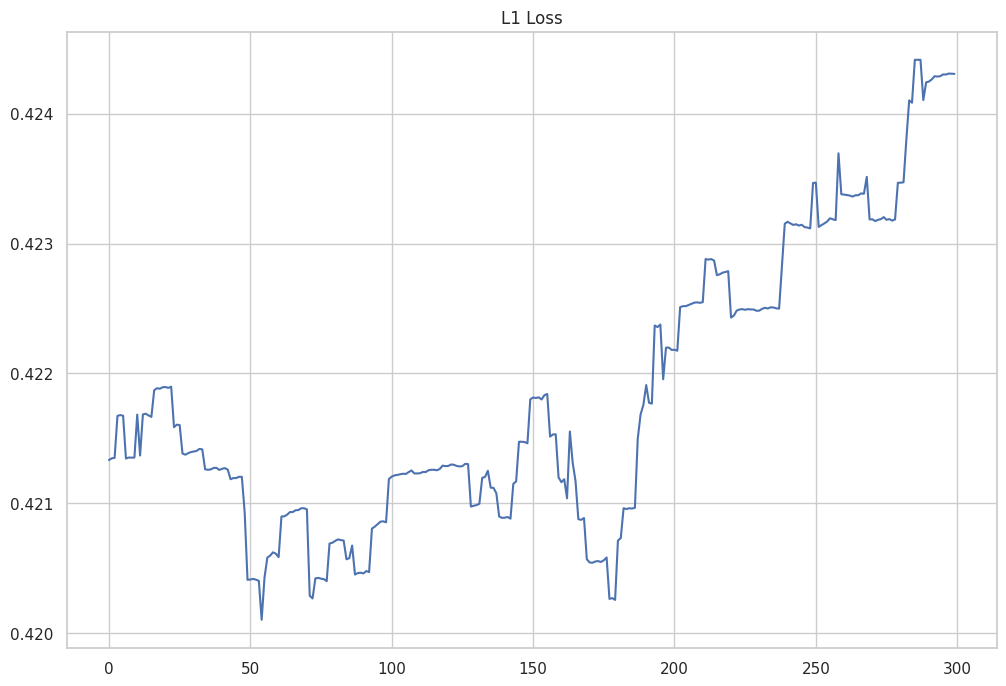

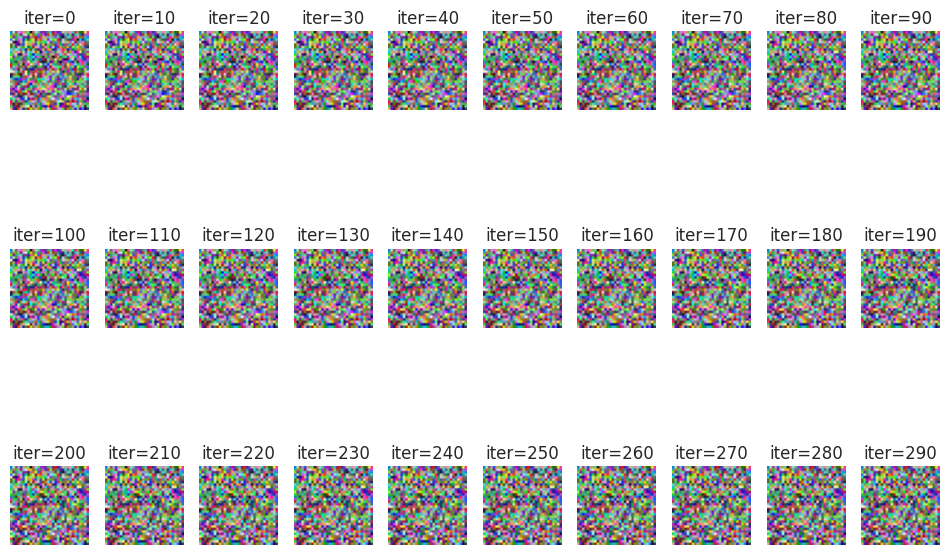

Dummy label is 1.
Dummy label is 20.
0 2.4750
10 11.8065
20 11.8065
30 11.8065
40 11.8065
50 11.8065
60 11.8065
70 11.8065
80 11.8065
90 11.8065
100 11.8065
110 11.8065
120 11.8065
130 11.8065
140 11.8065
150 11.8065
160 11.8065
170 11.8065
180 11.8065
190 11.8065
200 11.8065
210 11.8065
220 11.8065
230 11.8065
240 11.8065
250 11.8065
260 11.8065
270 11.8065
280 11.8065
290 11.8065


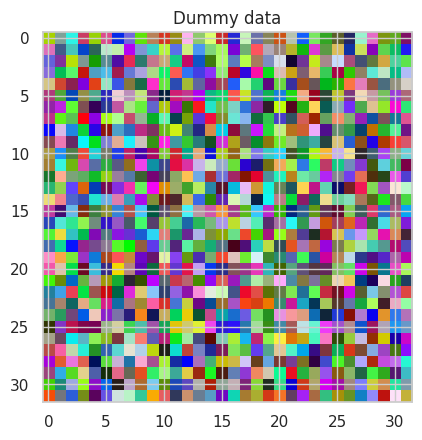

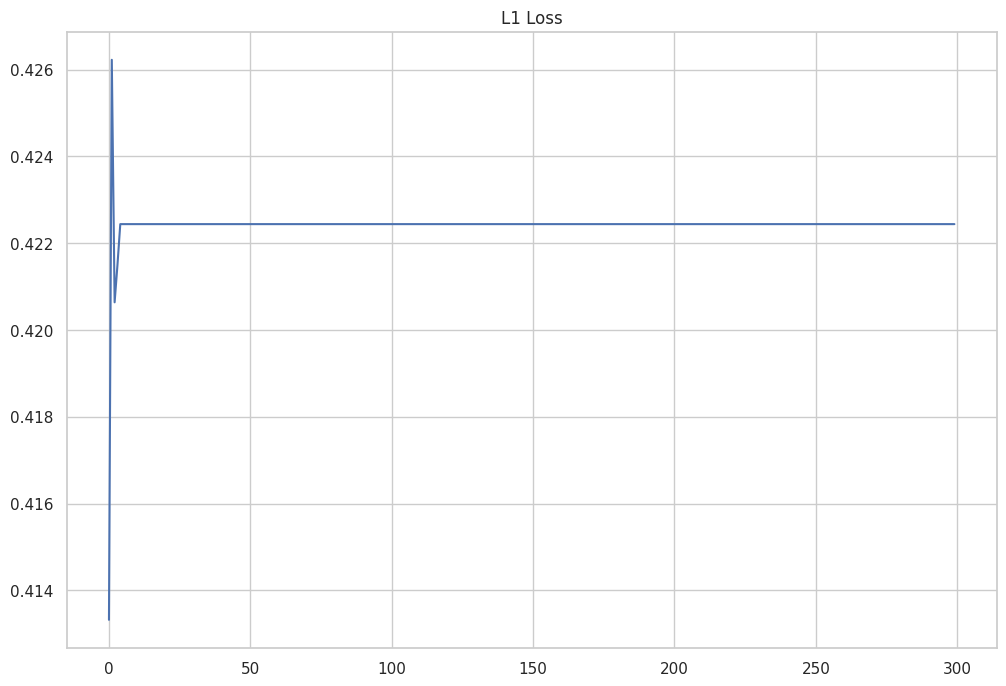

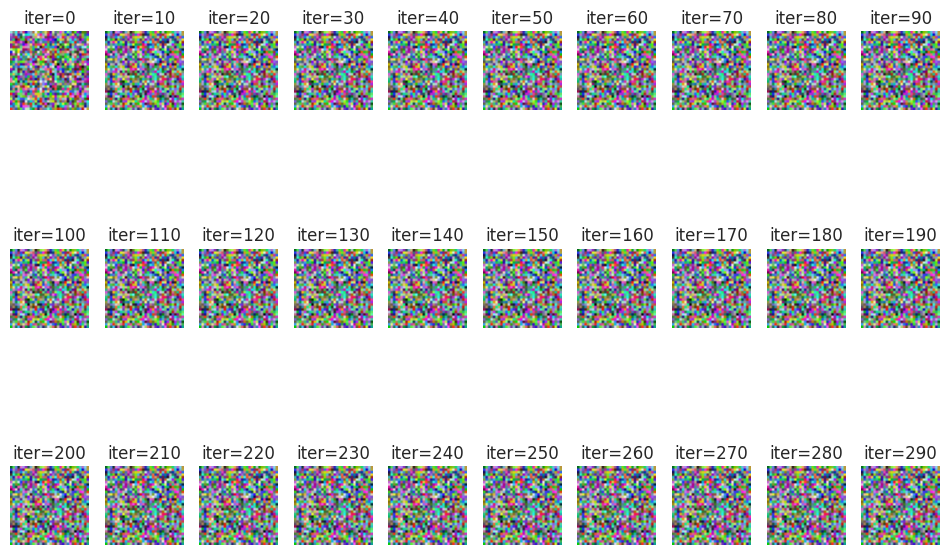

Dummy label is 4.
Dummy label is 67.
0 1.0892
10 0.6341
20 0.6047
30 0.5972
40 0.5922
50 0.5895
60 0.5875
70 0.5863
80 0.5853
90 0.5846
100 0.5840
110 0.5836
120 0.5832
130 0.5830
140 0.5827
150 0.5825
160 0.5823
170 0.5822
180 0.5821
190 0.5819
200 0.5818
210 0.5816
220 0.5815
230 0.5814
240 0.5814
250 0.5813
260 0.5812
270 0.5812
280 0.5812
290 0.5811


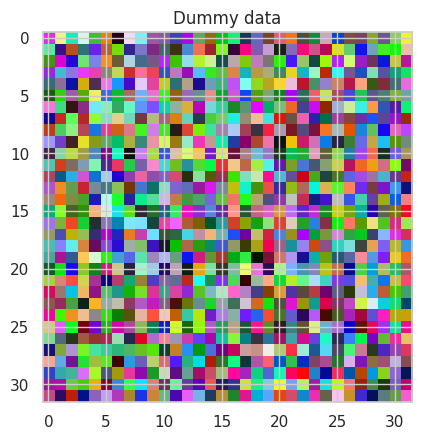

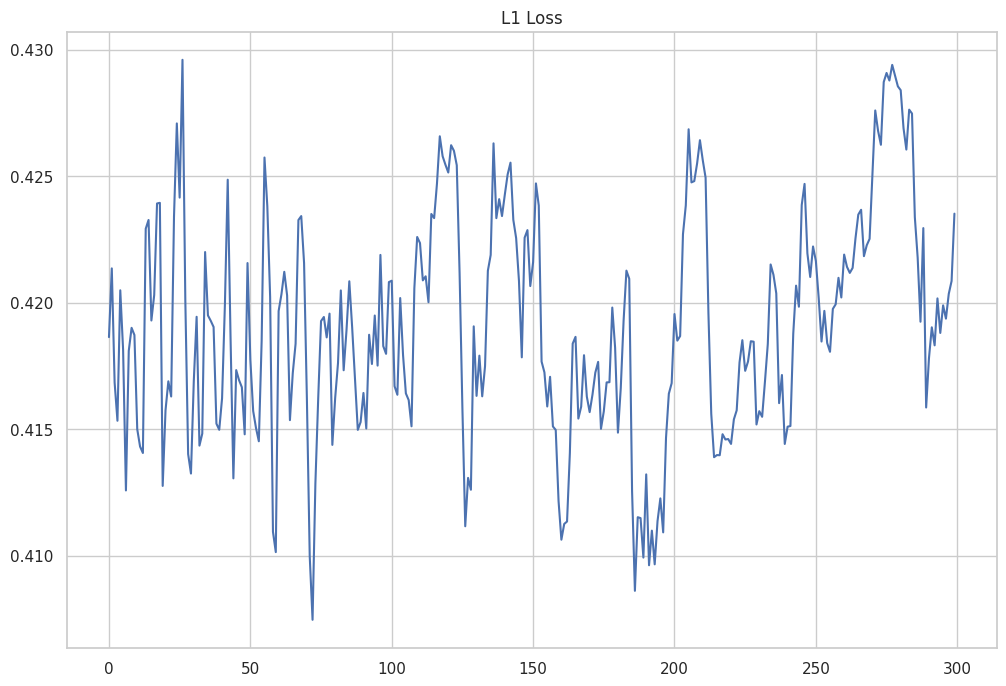

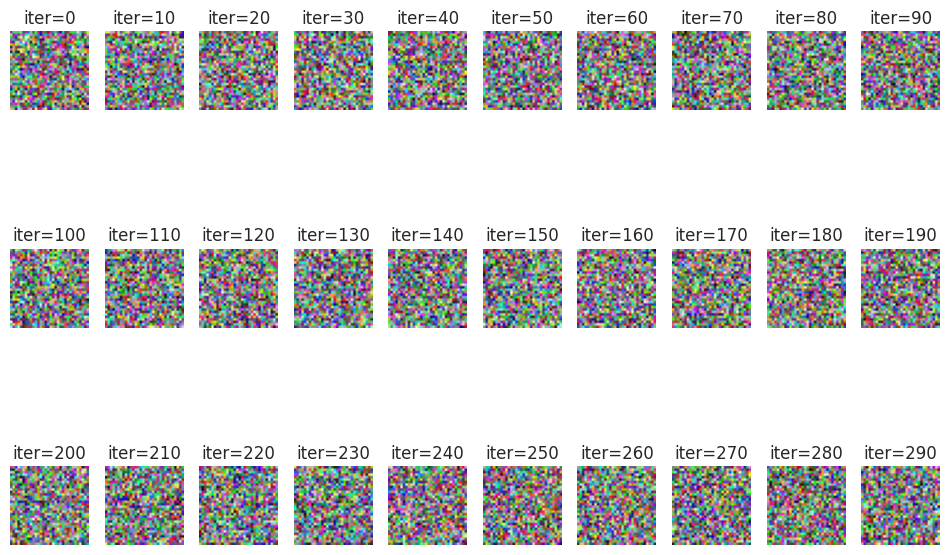

Dummy label is 8.


In [95]:
for epoch in [1,10,20]:

    # Load the models and their respective gradients
    net = torch.load(f"checkpoints/model_epoch_{epoch}.pth")
    model = LeNet().to(device)
    model.load_state_dict(net)
    original_dy_dx = torch.load(f"checkpoints/gradients_epoch_{epoch}.pth")
    
    reconstruct(model, original_dy_dx, gt_data.size(), gt_onehot_label.size())
    
